In [97]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')


In [98]:
data_path = Path("all_events_clustered.parquet")
df = pd.read_parquet(data_path)
df = df[df["cluster"] != -1].copy()
df["window_start"] = pd.to_datetime(df["window_start"], errors="coerce")
df = df.sort_values(["src_ip", "window_start"]).reset_index(drop=True)

print(f"Loaded {len(df):,} records")
print(f"Cluster distribution:\n{df['cluster'].value_counts().sort_index()}")

Loaded 8,373 records
Cluster distribution:
cluster
0      140
10    7495
11     359
12     143
13     104
14     109
15      23
Name: count, dtype: int64


In [99]:
df = df[df["cluster"] != -1].copy()

df["label"] = None
df.loc[df["cluster"] == 0, "label"] = "BENIGN"

if "characterization" in df.columns:
    mask = df["characterization"].notna()
    char = df.loc[mask, "characterization"].astype(str).str.lower()

    df.loc[mask & char.str.contains("short-interval|moderate-interval", regex=True), "label"] = "FAST_ATTACK"
    df.loc[mask & char.str.contains("long-interval", regex=True), "label"] = "SLOW_ATTACK"
else:
    cluster_to_label = {
        0: "BENIGN",
        10: "FAST_ATTACK",
        11: "FAST_ATTACK",
        14: "FAST_ATTACK",
        12: "SLOW_ATTACK",
        13: "SLOW_ATTACK",
        15: "SLOW_ATTACK"
    }
    df["label"] = df["cluster"].map(cluster_to_label)

df = df[df["label"].notna()].copy()

print(f"Total records: {len(df):,}")
print(f"Label distribution (natural):\n{df['label'].value_counts().sort_index()}")


Total records: 8,373
Label distribution (natural):
label
BENIGN          140
FAST_ATTACK    7742
SLOW_ATTACK     491
Name: count, dtype: int64


In [100]:
events_df = pd.read_parquet("all_events.parquet")
events_df["ts"] = pd.to_datetime(events_df["ts"], errors="coerce")
events_df["day"] = events_df["ts"].dt.date
events_df = events_df[events_df["ts"].notna()].copy()

failed_events = events_df[events_df["event_type"] == "failed_password"].copy()

def compute_window_num_failed_days(group):
    group = group.sort_values("window_start").reset_index()
    results = []
    
    for _, row in group.iterrows():
        src_ip = row["src_ip"]
        window_start = row["window_start"]
        
        ip_failed = failed_events[
            (failed_events["src_ip"] == src_ip) & 
            (failed_events["ts"] <= window_start)
        ]
        
        num_days = ip_failed["day"].nunique() if len(ip_failed) > 0 else 0
        results.append(num_days)
    
    result_series = pd.Series(results, index=group["index"])
    return result_series

num_failed_days_series = df.groupby("src_ip", group_keys=False).apply(compute_window_num_failed_days)
df["num_failed_days"] = num_failed_days_series.reindex(df.index).fillna(0).astype(int)

print(f"Recomputed num_failed_days for {len(df):,} windows")
print(f"num_failed_days range: {df['num_failed_days'].min()} - {df['num_failed_days'].max()}")


Recomputed num_failed_days for 8,373 windows
num_failed_days range: 0 - 24


In [163]:
paper_features = [
    "n_failed_password",
    "n_distinct_users",
    "avg_time_between_attempts",
    "num_failed_ports",
    "success_ratio",
    "login_interval_variance",
    "username_entropy",
    "time_of_day_avg",
    "num_failed_days"
]

for col in paper_features:
    if col not in df.columns:
        df[col] = 0.0
    df[col] = df[col].fillna(0).astype(float)

label_encoder = LabelEncoder()
df["label_encoded"] = label_encoder.fit_transform(df["label"])

print(f"Features prepared: {len(paper_features)} features")
print(f"Classes: {label_encoder.classes_}")
print(f"Total records: {len(df):,}")


Features prepared: 9 features
Classes: ['BENIGN' 'FAST_ATTACK' 'SLOW_ATTACK']
Total records: 8,373


In [164]:
sequence_length = 3

def create_sequences(group, seq_len=sequence_length):
    sequences = []
    labels = []
    group_sorted = group.sort_values("window_start")
    original_indices = group_sorted.index.tolist()
    
    if len(group_sorted) < seq_len + 1:
        return sequences, labels
    
    for i in range(len(group_sorted) - seq_len):
        seq_indices = original_indices[i:i+seq_len]
        sequences.append(seq_indices)
        labels.append(group_sorted.iloc[i+seq_len]["label"])
    
    return sequences, labels

all_sequences = []
all_labels = []

for ip, group in df.groupby("src_ip"):
    sequences, labels = create_sequences(group, seq_len=sequence_length)
    for seq_idx, label in zip(sequences, labels):
        all_sequences.append(seq_idx)
        all_labels.append(label)

print(f"Created {len(all_sequences):,} sequences")
print(f"Sequence length: {sequence_length}")
print(f"Label distribution (natural):\n{pd.Series(all_labels).value_counts().sort_index()}")


Created 2,770 sequences
Sequence length: 3
Label distribution (natural):
BENIGN           59
FAST_ATTACK    2266
SLOW_ATTACK     445
Name: count, dtype: int64


In [165]:
X_features_raw = df[paper_features].values
y_seq_labels = np.array(all_labels)
y_seq = label_encoder.transform(y_seq_labels)

X_seq_raw = np.array([X_features_raw[seq] for seq in all_sequences])

unique_ips = df["src_ip"].unique()
ip_labels = df.groupby("src_ip")["label"].first()

train_ips, test_ips = train_test_split(
    unique_ips, 
    test_size=0.2, 
    random_state=42,
    stratify=ip_labels[unique_ips] if len(ip_labels[unique_ips].unique()) > 1 else None
)

train_mask = df["src_ip"].isin(train_ips)
train_indices = set(df[train_mask].index.tolist())
test_indices = set(df[~train_mask].index.tolist())

train_seq_mask = [all(seq_idx in train_indices for seq_idx in seq) for seq in all_sequences]
test_seq_mask = [all(seq_idx in test_indices for seq_idx in seq) for seq in all_sequences]

X_train_raw = X_seq_raw[train_seq_mask]
y_train_labels = y_seq_labels[train_seq_mask]
y_train = y_seq[train_seq_mask]
X_test_raw = X_seq_raw[test_seq_mask]
y_test_labels = y_seq_labels[test_seq_mask]
y_test = y_seq[test_seq_mask]

print(f"Train sequences (before balancing): {len(X_train_raw):,}")
print(f"Test sequences: {len(X_test_raw):,}")
print(f"Train label distribution (natural):\n{pd.Series(y_train_labels).value_counts().sort_index()}")
print(f"Test label distribution (natural):\n{pd.Series(y_test_labels).value_counts().sort_index()}")


Train sequences (before balancing): 2,127
Test sequences: 643
Train label distribution (natural):
BENIGN           44
FAST_ATTACK    1799
SLOW_ATTACK     284
Name: count, dtype: int64
Test label distribution (natural):
BENIGN          15
FAST_ATTACK    467
SLOW_ATTACK    161
Name: count, dtype: int64


In [166]:
train_label_counts = pd.Series(y_train_labels).value_counts()

benign_label = "BENIGN"
fast_label = "FAST_ATTACK"
slow_label = "SLOW_ATTACK"

benign_idx = label_encoder.transform([benign_label])[0]
fast_idx = label_encoder.transform([fast_label])[0]
slow_idx = label_encoder.transform([slow_label])[0]

benign_count = train_label_counts.get(benign_label, 0)
fast_count = train_label_counts.get(fast_label, 0)
slow_count = train_label_counts.get(slow_label, 0)

target_ratios = {
    "BENIGN": 1,
    "FAST_ATTACK": 8,
    "SLOW_ATTACK": 4
}

target_fast_from_benign = int(benign_count * target_ratios["FAST_ATTACK"])
target_fast_from_slow = int(slow_count * (target_ratios["FAST_ATTACK"] / target_ratios["SLOW_ATTACK"])) if slow_count > 0 else fast_count
target_fast = min(fast_count, target_fast_from_benign, target_fast_from_slow)

target_sizes = {
    benign_idx: benign_count,
    slow_idx: slow_count,
    fast_idx: target_fast
}

balanced_indices = []
for label_idx, target in target_sizes.items():
    label_mask = y_train == label_idx
    label_indices = np.where(label_mask)[0]
    if len(label_indices) > target:
        selected_indices = resample(
            label_indices,
            replace=False,
            n_samples=target,
            random_state=42
        )
    else:
        selected_indices = label_indices
    balanced_indices.extend(selected_indices)

X_train_balanced = X_train_raw[balanced_indices]
y_train_balanced_labels = y_train_labels[balanced_indices]
y_train_balanced = y_train[balanced_indices]

print(f"Train sequences (after balancing): {len(X_train_balanced):,}")
print(f"Train label distribution (balanced):\n{pd.Series(y_train_balanced_labels).value_counts().sort_index()}")


Train sequences (after balancing): 680
Train label distribution (balanced):
BENIGN          44
FAST_ATTACK    352
SLOW_ATTACK    284
Name: count, dtype: int64


In [167]:
scaler = StandardScaler()
X_train_flat = X_train_balanced.reshape(-1, X_train_balanced.shape[-1])
X_test_flat = X_test_raw.reshape(-1, X_test_raw.shape[-1])

scaler.fit(X_train_flat)
X_train_scaled_flat = scaler.transform(X_train_flat)
X_test_scaled_flat = scaler.transform(X_test_flat)

X_train = X_train_scaled_flat.reshape(X_train_balanced.shape)
X_test = X_test_scaled_flat.reshape(X_test_raw.shape)

n_classes = len(label_encoder.classes_)
y_train_cat = to_categorical(y_train_balanced, num_classes=n_classes)
y_test_cat = to_categorical(y_test, num_classes=n_classes)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


X_train shape: (680, 3, 9)
X_test shape: (643, 3, 9)


In [ ]:
n_features = X_train.shape[2]

def focal_loss(alpha=0.25, gamma=2.0):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-8, 1 - 1e-8)
        ce_loss = -y_true * tf.math.log(y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        focal_weight = alpha * tf.pow(1 - p_t, gamma)
        focal_loss = focal_weight * ce_loss
        return tf.reduce_mean(tf.reduce_sum(focal_loss, axis=1))
    return focal_loss_fixed

model = Sequential([
    LSTM(32, return_sequences=False, input_shape=(sequence_length, n_features)),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(n_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=focal_loss(alpha=0.25, gamma=2.0),
    metrics=['accuracy']
)

model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 32)             │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,955 (23.26 KB)

 Trainable params: 5,955 (23.26 KB)

 Non-trainable params: 0 (0.00 B)

In [169]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-7, verbose=1)

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=150,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.5441 - loss: 0.1078 - val_accuracy: 0.8149 - val_loss: 0.0872 - learning_rate: 0.0010
Epoch 2/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7368 - loss: 0.0806 - val_accuracy: 0.8476 - val_loss: 0.0653 - learning_rate: 0.0010
Epoch 3/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7941 - loss: 0.0627 - val_accuracy: 0.8507 - val_loss: 0.0501 - learning_rate: 0.0010
Epoch 4/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8044 - loss: 0.0498 - val_accuracy: 0.8491 - val_loss: 0.0396 - learning_rate: 0.0010
Epoch 5/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8221 - loss: 0.0426 - val_accuracy: 0.8414 - val_loss: 0.0352 - learning_rate: 0.0010
Epoch 6/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8015 - loss: 0.0375 - val_accuracy: 0.8538 - val_loss: 0.0316 - learning_rate: 0.0010
Epoch 7/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7897 - loss: 0.0357 - val_

In [170]:
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, labels=range(len(label_encoder.classes_)), target_names=[str(c) for c in label_encoder.classes_]))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred, labels=range(len(label_encoder.classes_))))


Test Accuracy: 0.9238

Classification Report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00        15
 FAST_ATTACK       0.95      0.95      0.95       467
 SLOW_ATTACK       0.85      0.84      0.85       161

    accuracy                           0.92       643
   macro avg       0.93      0.93      0.93       643
weighted avg       0.92      0.92      0.92       643


Confusion Matrix:
[[ 15   0   0]
 [  0 443  24]
 [  0  25 136]]


In [171]:
models_dir = Path("models")
models_dir.mkdir(exist_ok=True)

model.save(models_dir / "lstm_model.keras")
with open(models_dir / "scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
with open(models_dir / "label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)
with open(models_dir / "model_config.pkl", "wb") as f:
    pickle.dump({"sequence_length": sequence_length, "features": paper_features}, f)


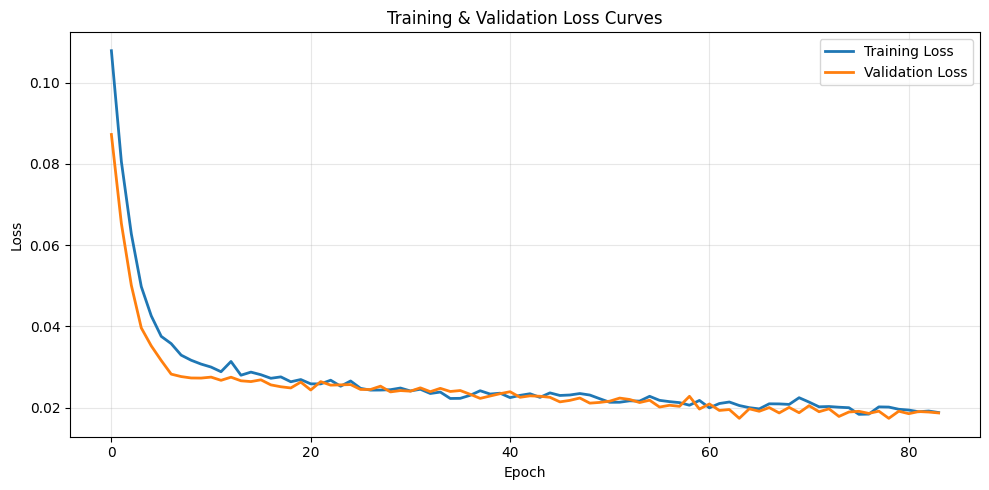

In [172]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


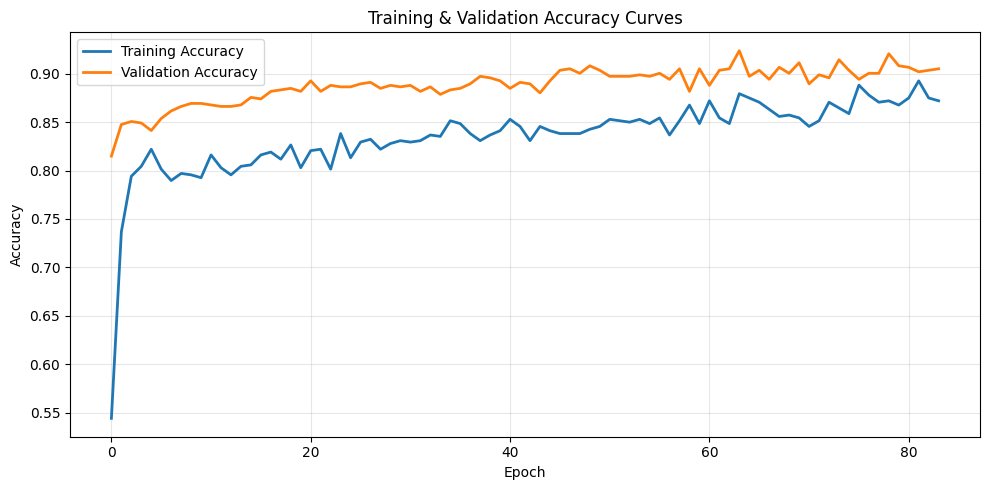

In [173]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


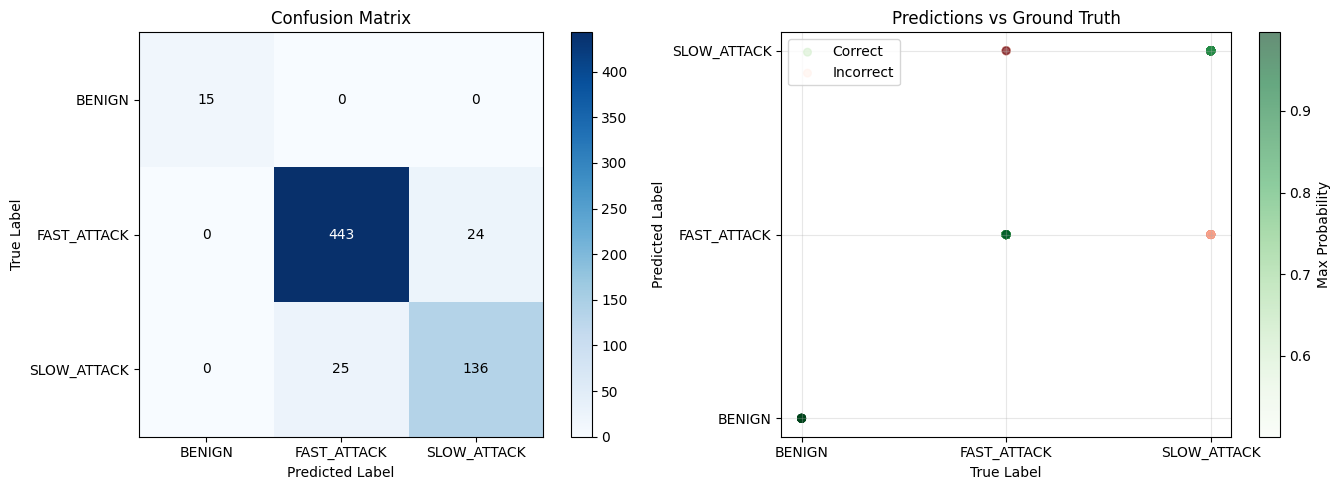

In [174]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm = confusion_matrix(y_test, y_pred, labels=range(len(label_encoder.classes_)))
im = axes[0].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
axes[0].figure.colorbar(im, ax=axes[0])
axes[0].set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
            title='Confusion Matrix', ylabel='True Label', xlabel='Predicted Label')
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        axes[0].text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

pred_proba_max = np.max(y_pred_proba, axis=1)
correct_mask = y_pred == y_test
axes[1].scatter(y_test[correct_mask], y_pred[correct_mask], 
                c=pred_proba_max[correct_mask], cmap='Greens', alpha=0.6, s=30, label='Correct')
axes[1].scatter(y_test[~correct_mask], y_pred[~correct_mask], 
                c=pred_proba_max[~correct_mask], cmap='Reds', alpha=0.6, s=30, label='Incorrect')
axes[1].set_xlabel('True Label')
axes[1].set_ylabel('Predicted Label')
axes[1].set_title('Predictions vs Ground Truth')
axes[1].set_xticks(range(len(label_encoder.classes_)))
axes[1].set_xticklabels(label_encoder.classes_)
axes[1].set_yticks(range(len(label_encoder.classes_)))
axes[1].set_yticklabels(label_encoder.classes_)
axes[1].legend()
axes[1].grid(True, alpha=0.3)
if len(axes[1].collections) > 0:
    plt.colorbar(axes[1].collections[0], ax=axes[1], label='Max Probability')
plt.tight_layout()
plt.show()


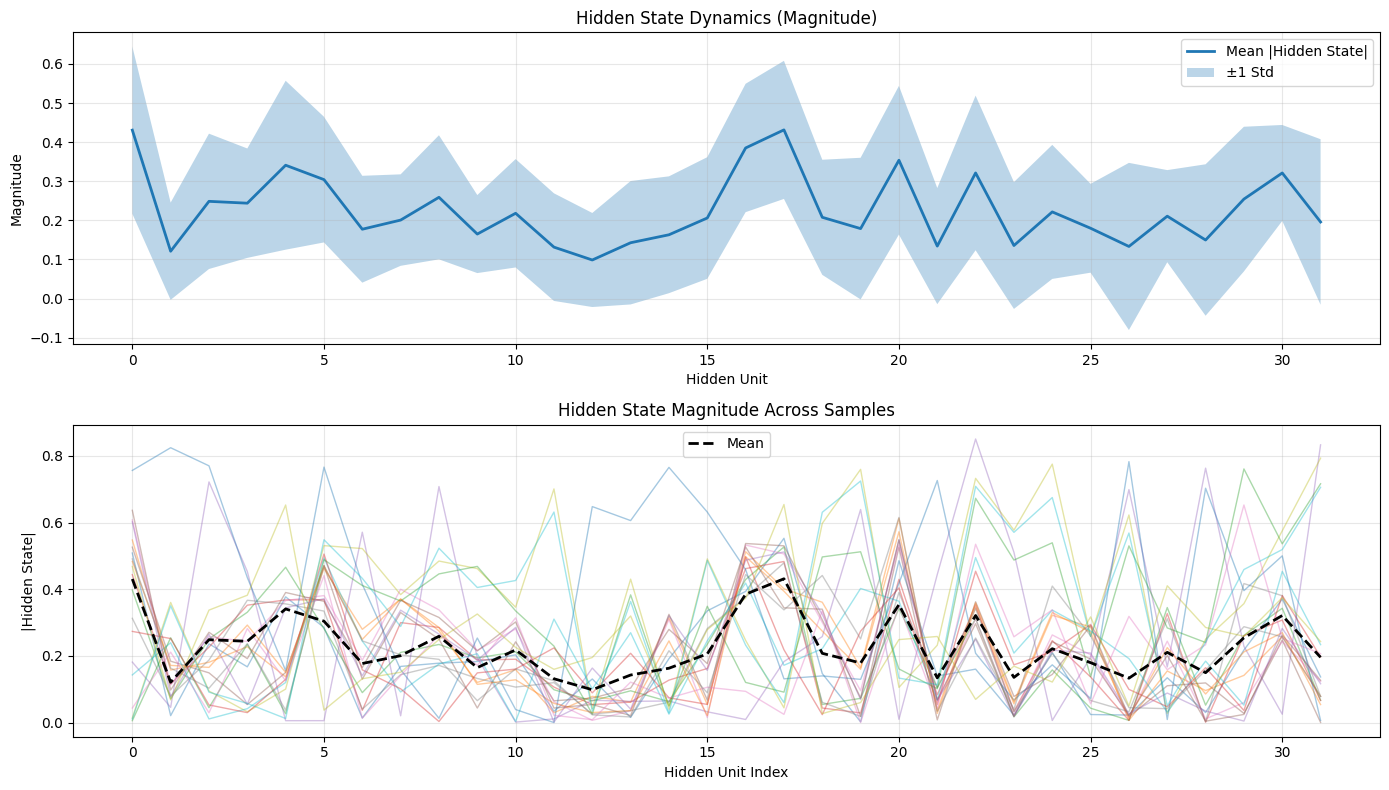

In [175]:
lstm_layer = model.layers[0]
hidden_model = Model(inputs=model.inputs, outputs=lstm_layer.output)

sample_size = min(100, len(X_test))
sample_indices = np.random.choice(len(X_test), sample_size, replace=False)
X_sample = X_test[sample_indices]

hidden_states = hidden_model.predict(X_sample, verbose=0)

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

mean_hidden = np.mean(np.abs(hidden_states), axis=0)
std_hidden = np.std(np.abs(hidden_states), axis=0)

axes[0].plot(mean_hidden, label='Mean |Hidden State|', linewidth=2)
axes[0].fill_between(range(len(mean_hidden)), 
                     mean_hidden - std_hidden, 
                     mean_hidden + std_hidden, 
                     alpha=0.3, label='±1 Std')
axes[0].set_xlabel('Hidden Unit')
axes[0].set_ylabel('Magnitude')
axes[0].set_title('Hidden State Dynamics (Magnitude)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

hidden_magnitude = np.abs(hidden_states)
for i in range(min(20, hidden_magnitude.shape[0])):
    axes[1].plot(hidden_magnitude[i], alpha=0.4, linewidth=1)
axes[1].plot(mean_hidden, color='black', linewidth=2, label='Mean', linestyle='--')
axes[1].set_xlabel('Hidden Unit Index')
axes[1].set_ylabel('|Hidden State|')
axes[1].set_title('Hidden State Magnitude Across Samples')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


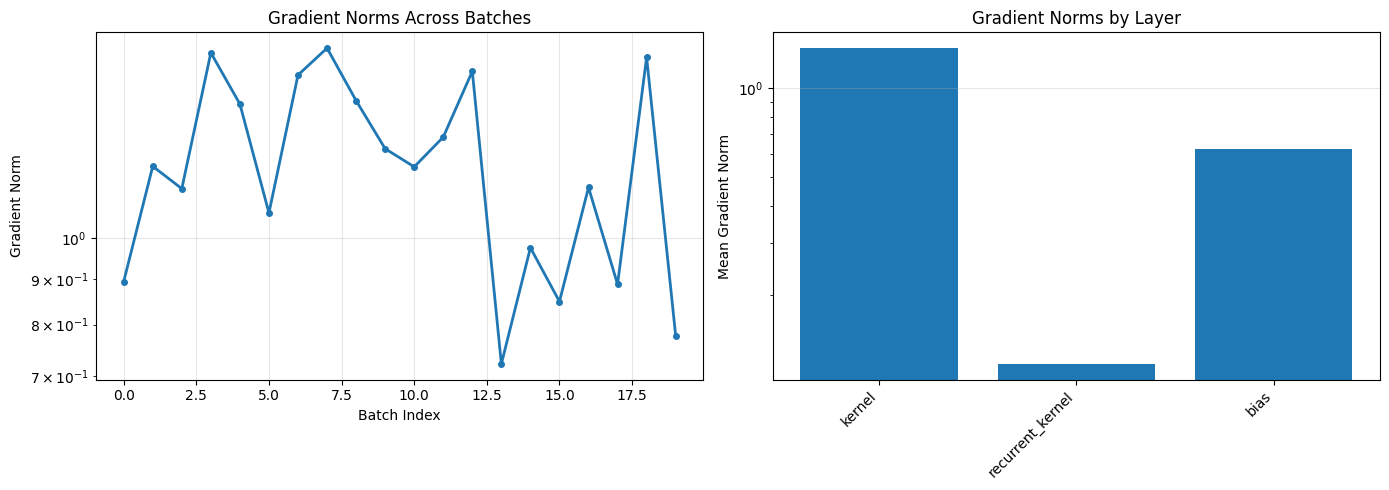

In [176]:
n_batches = 20
batch_gradients = []

for i in range(n_batches):
    indices = np.random.choice(len(X_test), min(32, len(X_test)), replace=False)
    X_batch = tf.constant(X_test[indices], dtype=tf.float32)
    y_batch = y_test_cat[indices]
    
    with tf.GradientTape() as tape:
        predictions = model(X_batch, training=False)
        loss = tf.keras.losses.categorical_crossentropy(y_batch, predictions)
        loss = tf.reduce_mean(loss)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    grad_norm = tf.linalg.global_norm(gradients)
    batch_gradients.append(float(grad_norm))

layer_grad_norms = {}
indices = np.random.choice(len(X_test), min(32, len(X_test)), replace=False)
X_batch = tf.constant(X_test[indices], dtype=tf.float32)
y_batch = y_test_cat[indices]

with tf.GradientTape() as tape:
    predictions = model(X_batch, training=False)
    loss = tf.keras.losses.categorical_crossentropy(y_batch, predictions)
    loss = tf.reduce_mean(loss)

gradients = tape.gradient(loss, model.trainable_variables)

for var, grad in zip(model.trainable_variables, gradients):
    if grad is not None:
        layer_name = var.name.split('/')[0]
        if layer_name not in layer_grad_norms:
            layer_grad_norms[layer_name] = []
        layer_grad_norms[layer_name].append(float(tf.norm(grad)))

for layer_name in layer_grad_norms:
    layer_grad_norms[layer_name] = np.sum(layer_grad_norms[layer_name])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(batch_gradients, marker='o', linewidth=2, markersize=4)
axes[0].set_xlabel('Batch Index')
axes[0].set_ylabel('Gradient Norm')
axes[0].set_title('Gradient Norms Across Batches')
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')

layer_names = list(layer_grad_norms.keys())
layer_norms = [layer_grad_norms[name] for name in layer_names]
axes[1].bar(range(len(layer_names)), layer_norms)
axes[1].set_xticks(range(len(layer_names)))
axes[1].set_xticklabels(layer_names, rotation=45, ha='right')
axes[1].set_ylabel('Mean Gradient Norm')
axes[1].set_title('Gradient Norms by Layer')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()


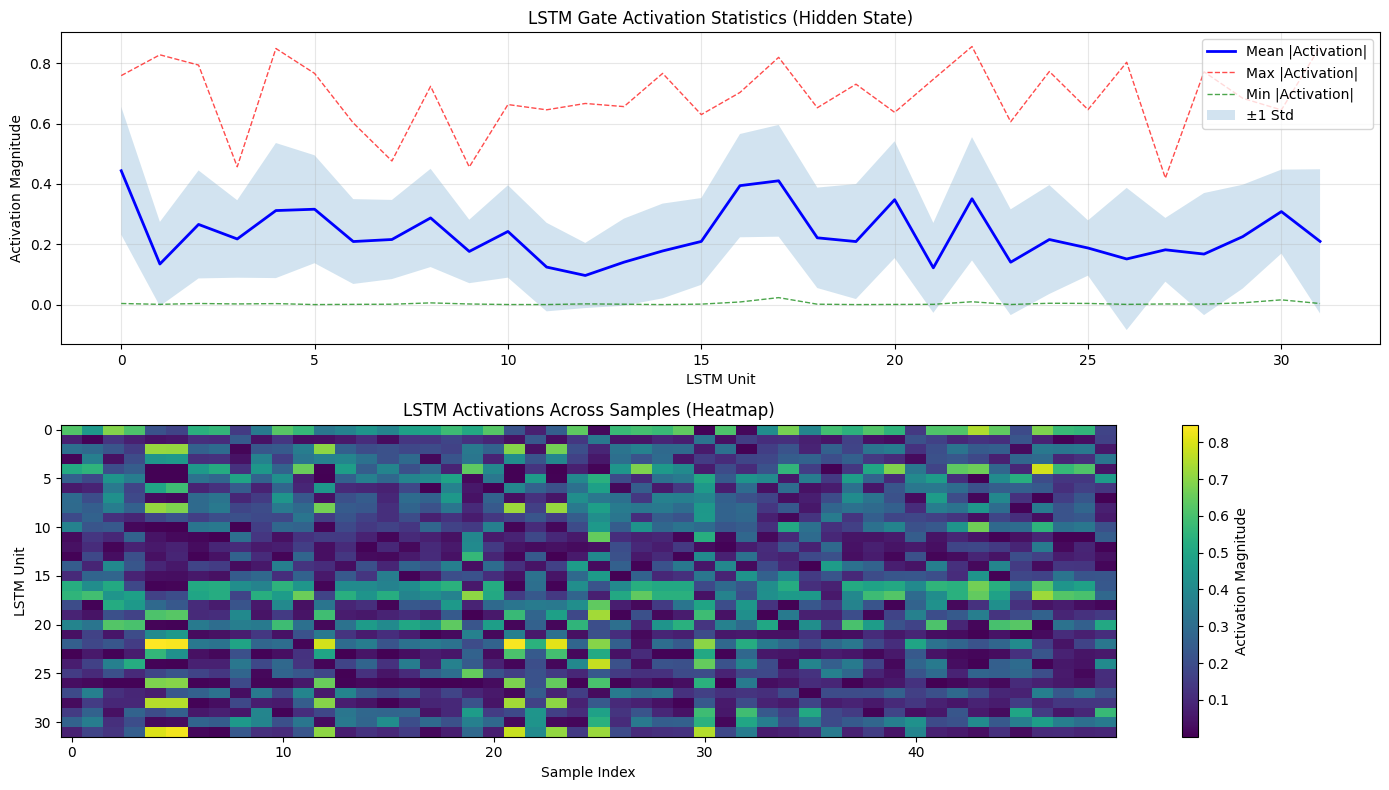

In [177]:
lstm_layer = model.layers[0]
lstm_model = Model(inputs=model.inputs, outputs=lstm_layer.output)

sample_size = min(100, len(X_test))
sample_indices = np.random.choice(len(X_test), sample_size, replace=False)
X_sample = X_test[sample_indices]

hidden_outputs = lstm_model.predict(X_sample, verbose=0)

activation_magnitude = np.abs(hidden_outputs)
mean_activation = np.mean(activation_magnitude, axis=0)
max_activation = np.max(activation_magnitude, axis=0)
min_activation = np.min(activation_magnitude, axis=0)
std_activation = np.std(activation_magnitude, axis=0)

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].plot(mean_activation, label='Mean |Activation|', linewidth=2, color='blue')
axes[0].plot(max_activation, label='Max |Activation|', linewidth=1, linestyle='--', alpha=0.7, color='red')
axes[0].plot(min_activation, label='Min |Activation|', linewidth=1, linestyle='--', alpha=0.7, color='green')
axes[0].fill_between(range(len(mean_activation)), 
                     mean_activation - std_activation, 
                     mean_activation + std_activation, 
                     alpha=0.2, label='±1 Std')
axes[0].set_xlabel('LSTM Unit')
axes[0].set_ylabel('Activation Magnitude')
axes[0].set_title('LSTM Gate Activation Statistics (Hidden State)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

im = axes[1].imshow(activation_magnitude[:min(50, activation_magnitude.shape[0])].T, 
                    aspect='auto', cmap='viridis', interpolation='nearest')
axes[1].set_xlabel('Sample Index')
axes[1].set_ylabel('LSTM Unit')
axes[1].set_title('LSTM Activations Across Samples (Heatmap)')
plt.colorbar(im, ax=axes[1], label='Activation Magnitude')
plt.tight_layout()
plt.show()


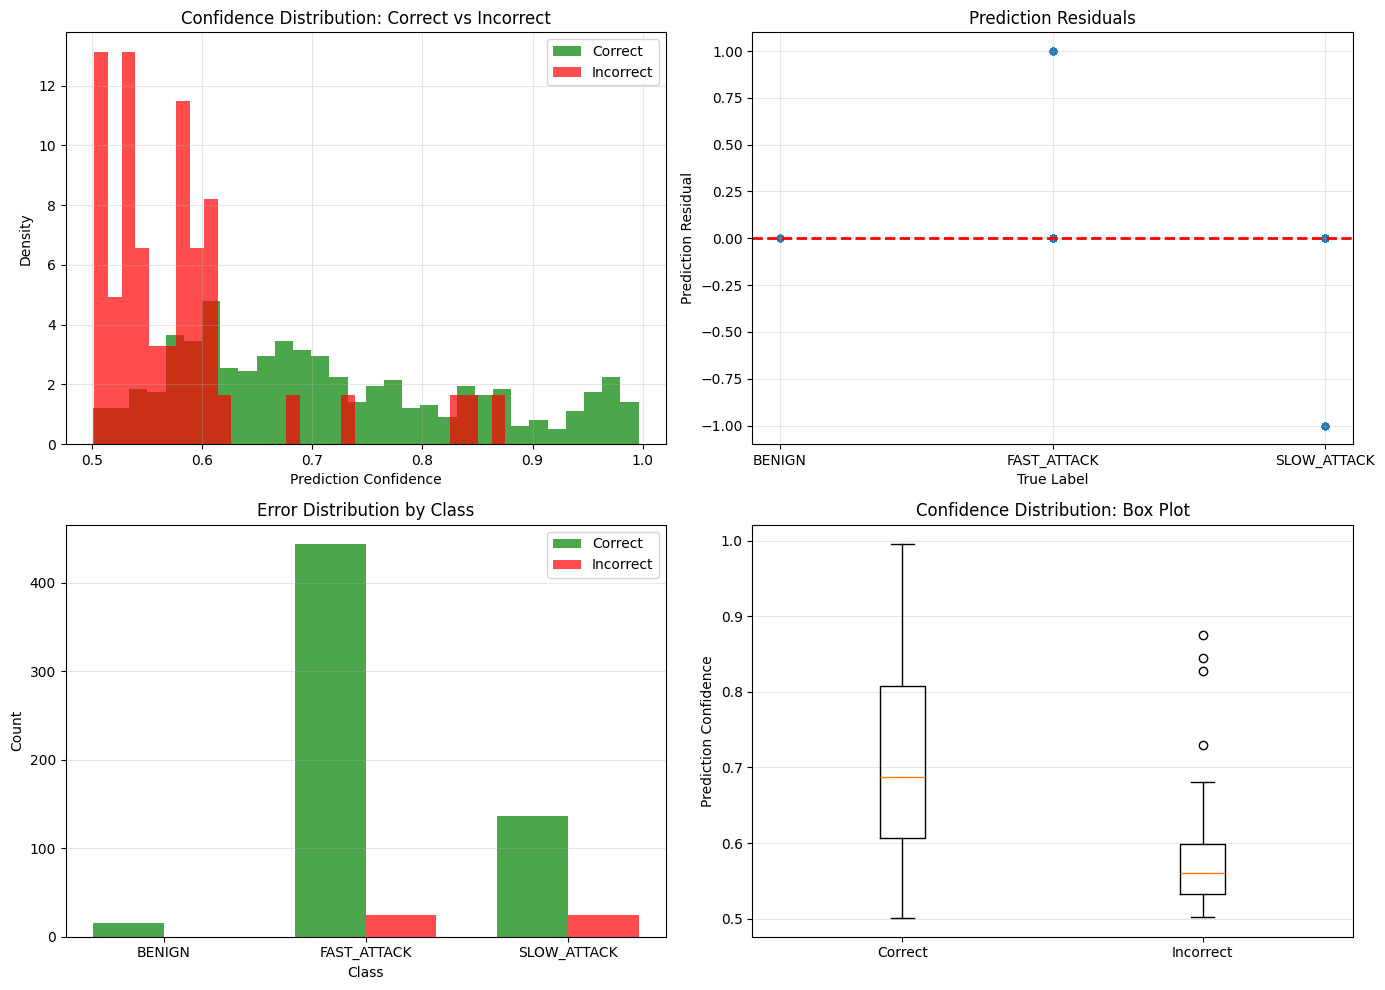

In [178]:
y_pred_flat = np.argmax(y_pred_proba, axis=1)
correct_predictions = (y_pred_flat == y_test)
prediction_confidence = np.max(y_pred_proba, axis=1)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].hist(prediction_confidence[correct_predictions], bins=30, alpha=0.7, 
                label='Correct', color='green', density=True)
axes[0, 0].hist(prediction_confidence[~correct_predictions], bins=30, alpha=0.7, 
                label='Incorrect', color='red', density=True)
axes[0, 0].set_xlabel('Prediction Confidence')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('Confidence Distribution: Correct vs Incorrect')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

residuals = y_pred_flat.astype(float) - y_test.astype(float)
axes[0, 1].scatter(y_test, residuals, alpha=0.5, s=20)
axes[0, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('True Label')
axes[0, 1].set_ylabel('Prediction Residual')
axes[0, 1].set_title('Prediction Residuals')
axes[0, 1].set_xticks(range(len(label_encoder.classes_)))
axes[0, 1].set_xticklabels(label_encoder.classes_)
axes[0, 1].grid(True, alpha=0.3)

class_names_list = [str(c) for c in label_encoder.classes_]
correct_counts = [np.sum((y_test == i) & correct_predictions) for i in range(len(class_names_list))]
incorrect_counts = [np.sum((y_test == i) & ~correct_predictions) for i in range(len(class_names_list))]
x = np.arange(len(class_names_list))
width = 0.35
axes[1, 0].bar(x - width/2, correct_counts, width, label='Correct', color='green', alpha=0.7)
axes[1, 0].bar(x + width/2, incorrect_counts, width, label='Incorrect', color='red', alpha=0.7)
axes[1, 0].set_xlabel('Class')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Error Distribution by Class')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(class_names_list)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

all_confidences_correct = prediction_confidence[correct_predictions]
all_confidences_incorrect = prediction_confidence[~correct_predictions]
box_data = []
box_labels = []
if len(all_confidences_correct) > 0:
    box_data.append(all_confidences_correct)
    box_labels.append('Correct')
if len(all_confidences_incorrect) > 0:
    box_data.append(all_confidences_incorrect)
    box_labels.append('Incorrect')
if box_data:
    axes[1, 1].boxplot(box_data, labels=box_labels)
    axes[1, 1].set_ylabel('Prediction Confidence')
    axes[1, 1].set_title('Confidence Distribution: Box Plot')
    axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


Unknown/Noise records (after filtering invalid IPs): 3,696
Created 1,186 sequences from unknown data

Predictions on Unknown/Noise data:
Total sequences: 1,186

Predicted label distribution:
FAST_ATTACK    1048
SLOW_ATTACK     138
Name: count, dtype: int64

Confidence statistics:
  Mean: 0.8400
  Median: 0.8339
  Min: 0.4954
  Max: 0.9963
  Std: 0.1056


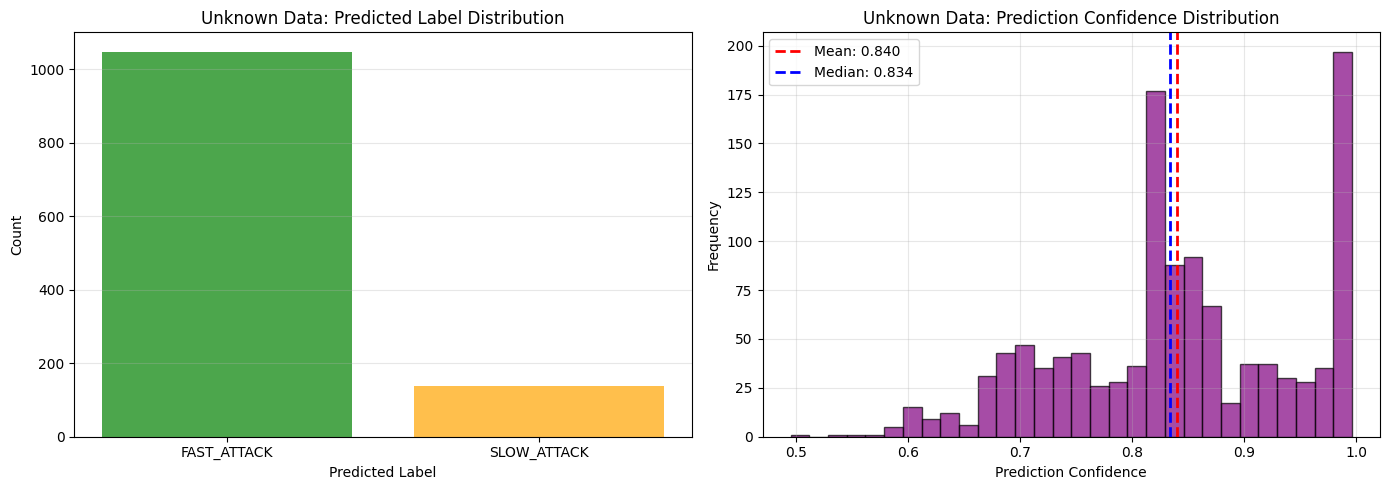

In [179]:
df_unknown = pd.read_parquet(data_path)
df_unknown = df_unknown[df_unknown["cluster"] == -1].copy()
df_unknown = df_unknown[df_unknown["src_ip"].notna()].copy()
df_unknown = df_unknown[df_unknown["src_ip"] != "0.0.0.0"].copy()
df_unknown = df_unknown[df_unknown["src_ip"] != ""].copy()
df_unknown["window_start"] = pd.to_datetime(df_unknown["window_start"], errors="coerce")
df_unknown = df_unknown.sort_values(["src_ip", "window_start"]).reset_index(drop=True)

print(f"Unknown/Noise records (after filtering invalid IPs): {len(df_unknown):,}")

for col in paper_features:
    if col not in df_unknown.columns:
        df_unknown[col] = 0.0
    df_unknown[col] = df_unknown[col].fillna(0).astype(float)

X_unknown_features = df_unknown[paper_features].values

def create_sequences_no_label(group, seq_len=sequence_length):
    sequences = []
    group_sorted = group.sort_values("window_start")
    original_indices = group_sorted.index.tolist()
    
    if len(group_sorted) < seq_len + 1:
        return sequences
    
    for i in range(len(group_sorted) - seq_len):
        seq_indices = original_indices[i:i+seq_len]
        sequences.append(seq_indices)
    
    return sequences

unknown_sequences = []
for ip, group in df_unknown.groupby("src_ip"):
    sequences = create_sequences_no_label(group, seq_len=sequence_length)
    for seq_idx in sequences:
        unknown_sequences.append(seq_idx)

print(f"Created {len(unknown_sequences):,} sequences from unknown data")

if len(unknown_sequences) > 0:
    X_unknown_raw = np.array([X_unknown_features[seq] for seq in unknown_sequences])
    X_unknown_flat = X_unknown_raw.reshape(-1, X_unknown_raw.shape[-1])
    X_unknown_scaled_flat = scaler.transform(X_unknown_flat)
    X_unknown = X_unknown_scaled_flat.reshape(X_unknown_raw.shape)
    
    y_unknown_proba = model.predict(X_unknown, verbose=0)
    y_unknown_pred = np.argmax(y_unknown_proba, axis=1)
    y_unknown_labels = label_encoder.inverse_transform(y_unknown_pred)
    y_unknown_confidence = np.max(y_unknown_proba, axis=1)
    
    print(f"\nPredictions on Unknown/Noise data:")
    print(f"Total sequences: {len(y_unknown_labels):,}")
    print(f"\nPredicted label distribution:")
    print(pd.Series(y_unknown_labels).value_counts().sort_index())
    print(f"\nConfidence statistics:")
    print(f"  Mean: {np.mean(y_unknown_confidence):.4f}")
    print(f"  Median: {np.median(y_unknown_confidence):.4f}")
    print(f"  Min: {np.min(y_unknown_confidence):.4f}")
    print(f"  Max: {np.max(y_unknown_confidence):.4f}")
    print(f"  Std: {np.std(y_unknown_confidence):.4f}")
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    pred_counts = pd.Series(y_unknown_labels).value_counts().sort_index()
    axes[0].bar(pred_counts.index, pred_counts.values, color=['green', 'orange', 'red'], alpha=0.7)
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Unknown Data: Predicted Label Distribution')
    axes[0].grid(True, alpha=0.3, axis='y')
    
    axes[1].hist(y_unknown_confidence, bins=30, alpha=0.7, color='purple', edgecolor='black')
    axes[1].axvline(np.mean(y_unknown_confidence), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(y_unknown_confidence):.3f}')
    axes[1].axvline(np.median(y_unknown_confidence), color='blue', linestyle='--', linewidth=2, label=f'Median: {np.median(y_unknown_confidence):.3f}')
    axes[1].set_xlabel('Prediction Confidence')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Unknown Data: Prediction Confidence Distribution')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No sequences created from unknown data (insufficient consecutive windows)")


In [180]:
slow_indices = np.where(y_unknown_labels == "SLOW_ATTACK")[0]
fast_indices = np.where(y_unknown_labels == "FAST_ATTACK")[0]

valid_slow_indices = []
for idx in slow_indices:
    seq = unknown_sequences[idx]
    src_ip = df_unknown.iloc[seq]["src_ip"].iloc[0]
    if not (pd.isna(src_ip) or src_ip == "0.0.0.0" or src_ip == ""):
        valid_slow_indices.append(idx)

valid_fast_indices = []
for idx in fast_indices:
    seq = unknown_sequences[idx]
    src_ip = df_unknown.iloc[seq]["src_ip"].iloc[0]
    if not (pd.isna(src_ip) or src_ip == "0.0.0.0" or src_ip == ""):
        valid_fast_indices.append(idx)

slow_with_confidence = [(idx, y_unknown_confidence[idx]) for idx in valid_slow_indices]
fast_with_confidence = [(idx, y_unknown_confidence[idx]) for idx in valid_fast_indices]

slow_with_confidence.sort(key=lambda x: x[1], reverse=True)
fast_with_confidence.sort(key=lambda x: x[1], reverse=True)

slow_ip_to_best = {}
for idx, conf in slow_with_confidence:
    seq = unknown_sequences[idx]
    src_ip = df_unknown.iloc[seq]["src_ip"].iloc[0]
    if src_ip not in slow_ip_to_best or conf > slow_ip_to_best[src_ip][1]:
        slow_ip_to_best[src_ip] = (idx, conf)

fast_ip_to_best = {}
for idx, conf in fast_with_confidence:
    seq = unknown_sequences[idx]
    src_ip = df_unknown.iloc[seq]["src_ip"].iloc[0]
    if src_ip not in fast_ip_to_best or conf > fast_ip_to_best[src_ip][1]:
        fast_ip_to_best[src_ip] = (idx, conf)

slow_unique_ip = sorted(slow_ip_to_best.values(), key=lambda x: x[1], reverse=True)
fast_unique_ip = sorted(fast_ip_to_best.values(), key=lambda x: x[1], reverse=True)

print(f"SLOW_ATTACK predictions: {len(slow_indices)} (valid IPs: {len(valid_slow_indices)}, unique IPs: {len(slow_unique_ip)})")
print(f"FAST_ATTACK predictions: {len(fast_indices)} (valid IPs: {len(valid_fast_indices)}, unique IPs: {len(fast_unique_ip)})")

if len(slow_with_confidence) > 0:
    print(f"SLOW_ATTACK confidence range: {slow_with_confidence[-1][1]:.4f} - {slow_with_confidence[0][1]:.4f}")
if len(fast_with_confidence) > 0:
    print(f"FAST_ATTACK confidence range: {fast_with_confidence[-1][1]:.4f} - {fast_with_confidence[0][1]:.4f}")

n_examples = 5
confidence_threshold = 0.85

high_conf_slow = [idx for idx, conf in slow_with_confidence if conf >= confidence_threshold]
high_conf_fast = [idx for idx, conf in fast_with_confidence if conf >= confidence_threshold]

print(f"\nHigh confidence predictions (>= {confidence_threshold}):")
print(f"  SLOW_ATTACK: {len(high_conf_slow)}")
print(f"  FAST_ATTACK: {len(high_conf_fast)}")

selected_slow = slow_unique_ip[:n_examples]
selected_fast = fast_unique_ip[:n_examples]

df_events = pd.read_parquet("all_events.parquet")
df_events["ts"] = pd.to_datetime(df_events["ts"], errors="coerce")
df_events = df_events.sort_values(["src_ip", "ts"])

print("\n" + "="*80)
print("SLOW_ATTACK PREDICTIONS - DETAILED EVENTS")
print("="*80)

for idx, (seq_idx, confidence) in enumerate(selected_slow, 1):
    seq = unknown_sequences[seq_idx]
    seq_rows = df_unknown.iloc[seq]
    
    src_ip = seq_rows["src_ip"].iloc[0]
    windows = seq_rows["window_start"].tolist()
    min_ts = min(windows)
    max_ts = max(windows) + pd.Timedelta(hours=1)
    
    print(f"\n--- Example {idx} (Highest Confidence: {confidence:.4f}) ---")
    print(f"Source IP: {src_ip}")
    print(f"Windows: {min_ts} to {max_ts}")
    
    print(f"\nModel Features (3-window sequence):")
    feature_df = seq_rows[paper_features].copy()
    feature_df.insert(0, "window_start", seq_rows["window_start"].values)
    print(feature_df.to_string(index=False))
    
    events = df_events[
        (df_events["src_ip"] == src_ip) & 
        (df_events["ts"] >= min_ts) & 
        (df_events["ts"] < max_ts)
    ].copy()
    
    print(f"\nNumber of events: {len(events)}")
    
    if len(events) > 0:
        failed_events = events[events['event_type'] == 'failed_password'].copy()
        if len(failed_events) > 1:
            failed_events = failed_events.sort_values("ts")
            time_diffs = failed_events["ts"].diff().dt.total_seconds().dropna()
            avg_time_between = time_diffs.mean() if len(time_diffs) > 0 else 0
            median_time_between = time_diffs.median() if len(time_diffs) > 0 else 0
        else:
            avg_time_between = 0
            median_time_between = 0
        
        print(f"\nEvent Summary:")
        print(f"  Failed passwords: {len(events[events['event_type'] == 'failed_password'])}")
        print(f"  Accepted sessions: {len(events[events['event_type'].str.contains('accepted', case=False, na=False)])}")
        print(f"  Distinct usernames: {events['username'].nunique()}")
        print(f"  Distinct source ports: {events['src_port'].nunique()}")
        if len(failed_events) > 1:
            print(f"  Actual avg time between failed attempts: {avg_time_between:.2f} seconds")
            print(f"  Actual median time between failed attempts: {median_time_between:.2f} seconds")
        
        print(f"\nFirst 10 events:")
        display_cols = ["ts", "event_type", "username", "src_port"]
        available_cols = [col for col in display_cols if col in events.columns]
        print(events[available_cols].head(10).to_string(index=False))
    else:
        print("No events found in all_events.parquet for this IP/time range")
    
    print("\n" + "-"*80)

print("\n" + "="*80)
print("FAST_ATTACK PREDICTIONS - DETAILED EVENTS")
print("="*80)

for idx, (seq_idx, confidence) in enumerate(selected_fast, 1):
    seq = unknown_sequences[seq_idx]
    seq_rows = df_unknown.iloc[seq]
    
    src_ip = seq_rows["src_ip"].iloc[0]
    windows = seq_rows["window_start"].tolist()
    min_ts = min(windows)
    max_ts = max(windows) + pd.Timedelta(hours=1)
    
    print(f"\n--- Example {idx} (Highest Confidence: {confidence:.4f}) ---")
    print(f"Source IP: {src_ip}")
    print(f"Windows: {min_ts} to {max_ts}")
    
    print(f"\nModel Features (3-window sequence):")
    feature_df = seq_rows[paper_features].copy()
    feature_df.insert(0, "window_start", seq_rows["window_start"].values)
    print(feature_df.to_string(index=False))
    
    events = df_events[
        (df_events["src_ip"] == src_ip) & 
        (df_events["ts"] >= min_ts) & 
        (df_events["ts"] < max_ts)
    ].copy()
    
    print(f"\nNumber of events: {len(events)}")
    
    if len(events) > 0:
        failed_events = events[events['event_type'] == 'failed_password'].copy()
        if len(failed_events) > 1:
            failed_events = failed_events.sort_values("ts")
            time_diffs = failed_events["ts"].diff().dt.total_seconds().dropna()
            avg_time_between = time_diffs.mean() if len(time_diffs) > 0 else 0
            median_time_between = time_diffs.median() if len(time_diffs) > 0 else 0
        else:
            avg_time_between = 0
            median_time_between = 0
        
        print(f"\nEvent Summary:")
        print(f"  Failed passwords: {len(events[events['event_type'] == 'failed_password'])}")
        print(f"  Accepted sessions: {len(events[events['event_type'].str.contains('accepted', case=False, na=False)])}")
        print(f"  Distinct usernames: {events['username'].nunique()}")
        print(f"  Distinct source ports: {events['src_port'].nunique()}")
        if len(failed_events) > 1:
            print(f"  Actual avg time between failed attempts: {avg_time_between:.2f} seconds")
            print(f"  Actual median time between failed attempts: {median_time_between:.2f} seconds")
        
        print(f"\nFirst 10 events:")
        display_cols = ["ts", "event_type", "username", "src_port"]
        available_cols = [col for col in display_cols if col in events.columns]
        print(events[available_cols].head(10).to_string(index=False))
    else:
        print("No events found in all_events.parquet for this IP/time range")
    
    print("\n" + "-"*80)


SLOW_ATTACK predictions: 138 (valid IPs: 138, unique IPs: 26)
FAST_ATTACK predictions: 1048 (valid IPs: 1048, unique IPs: 114)
SLOW_ATTACK confidence range: 0.4954 - 0.9641
FAST_ATTACK confidence range: 0.5305 - 0.9963

High confidence predictions (>= 0.85):
  SLOW_ATTACK: 102
  FAST_ATTACK: 408

SLOW_ATTACK PREDICTIONS - DETAILED EVENTS

--- Example 1 (Highest Confidence: 0.9641) ---
Source IP: 5.188.10.182
Windows: 2024-12-11 14:30:12 to 2024-12-12 16:30:30

Model Features (3-window sequence):
       window_start  n_failed_password  n_distinct_users  avg_time_between_attempts  num_failed_ports  success_ratio  login_interval_variance  username_entropy  time_of_day_avg  num_failed_days
2024-12-11 14:30:12                0.0               0.0                        5.0               0.0            0.0                      0.0               0.0          52214.5             24.0
2024-12-12 06:15:09                0.0               0.0                        4.0               0.0          

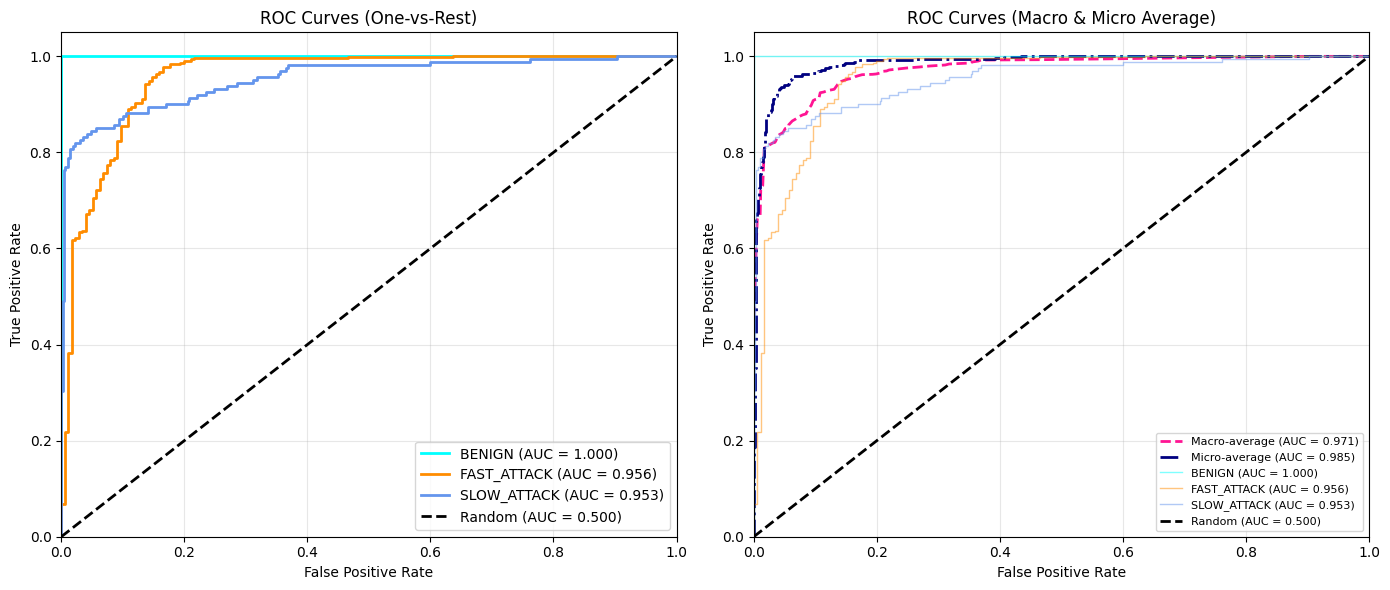


ROC-AUC Scores:
  Macro-average (OVR): 0.9697
  Micro-average (OVR): 0.9854
  Weighted-average (OVR): 0.9563

Per-class AUC:
  BENIGN: 1.0000
  FAST_ATTACK: 0.9559
  SLOW_ATTACK: 0.9533


In [181]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle

y_test_binarized = np.zeros((len(y_test), len(label_encoder.classes_)))
for i, label in enumerate(y_test):
    y_test_binarized[i, label] = 1

n_classes = len(label_encoder.classes_)
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i, color in zip(range(n_classes), colors):
    axes[0].plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'{label_encoder.classes_[i]} (AUC = {roc_auc[i]:.3f})')

axes[0].plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.500)')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves (One-vs-Rest)')
axes[0].legend(loc="lower right")
axes[0].grid(True, alpha=0.3)

macro_auc = roc_auc_score(y_test_binarized, y_pred_proba, average='macro', multi_class='ovr')
micro_auc = roc_auc_score(y_test_binarized, y_pred_proba, average='micro', multi_class='ovr')
weighted_auc = roc_auc_score(y_test_binarized, y_pred_proba, average='weighted', multi_class='ovr')

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr_macro = all_fpr
tpr_macro = mean_tpr
roc_auc_macro = auc(fpr_macro, tpr_macro)

axes[1].plot(fpr_macro, tpr_macro, color='deeppink', lw=2,
             label=f'Macro-average (AUC = {roc_auc_macro:.3f})', linestyle='--')

fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
axes[1].plot(fpr_micro, tpr_micro, color='navy', lw=2,
             label=f'Micro-average (AUC = {roc_auc_micro:.3f})', linestyle='-.')

for i, color in zip(range(n_classes), colors):
    axes[1].plot(fpr[i], tpr[i], color=color, lw=1, alpha=0.5,
                label=f'{label_encoder.classes_[i]} (AUC = {roc_auc[i]:.3f})')

axes[1].plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.500)')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves (Macro & Micro Average)')
axes[1].legend(loc="lower right", fontsize=8)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nROC-AUC Scores:")
print(f"  Macro-average (OVR): {macro_auc:.4f}")
print(f"  Micro-average (OVR): {micro_auc:.4f}")
print(f"  Weighted-average (OVR): {weighted_auc:.4f}")
print(f"\nPer-class AUC:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"  {class_name}: {roc_auc[i]:.4f}")